In [1]:
#
# Analysis of the BlockScience Labs: Uniswap model (WIP)
#
# Maintainer: Tyler Mace <tyler@blocksciencelabs.com>
# Notes: This notebook does not perform execution of the model -- only
#        analysis of the resulting data.
#

In [2]:
# Third party
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

# From our model work
sys.path.append("/home/jovyan/cadcad-uniswap")
from model.state import genesis_state
from model.utils.plot_utils import plot_fee_impact, plot_agenttype_return
from model.utils.post_processing import add_trading_volume

In [3]:
# Print a timestamp so we have context with our analysis
print("Execution Date:", datetime.now().strftime("%d/%b/%Y %H:%M UTC"))

Execution Date: 12/Oct/2022 20:42 UTC


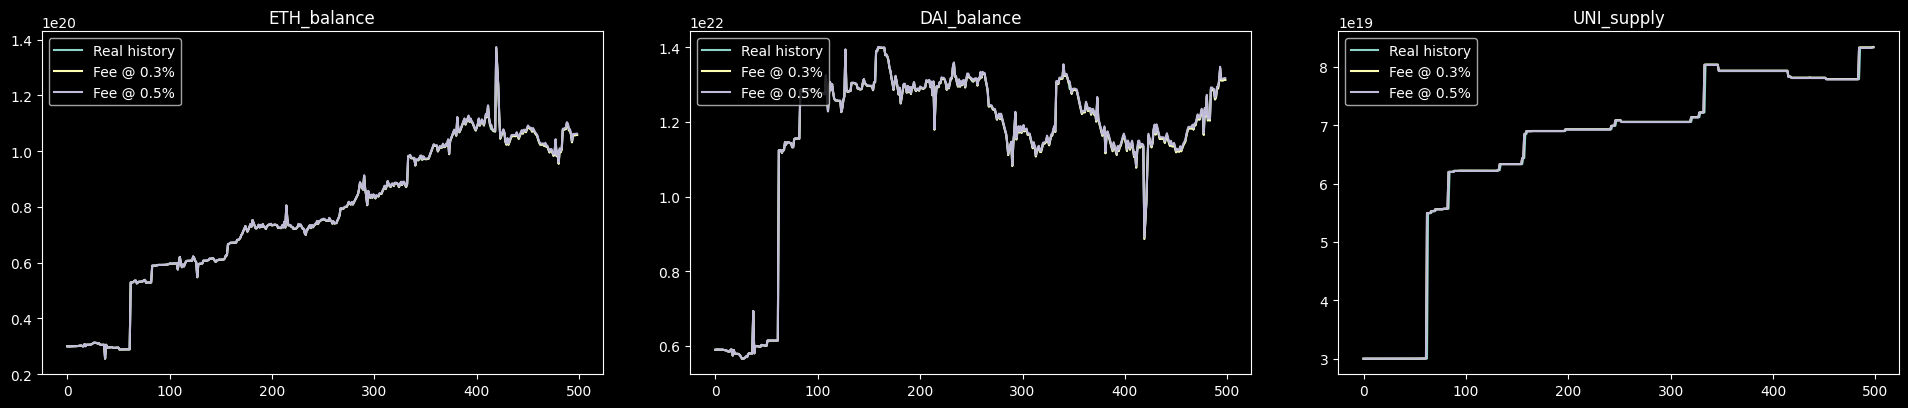

In [4]:
# Fee Impact Plots
plt.style.use('dark_background')
uniswap_events = pd.read_pickle('../data/simpler_uniswap_events.p')
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']
fees = [(1-(param/1000))*100 for param in genesis_state['fee_numerator']]
models = list()

exp_df = pd.read_pickle('../data/exp_df.p')

for i in exp_df['subset'].unique():
    models.append(exp_df.loc[exp_df['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply']].reset_index())

plot_fee_impact(models, fees, real_history)

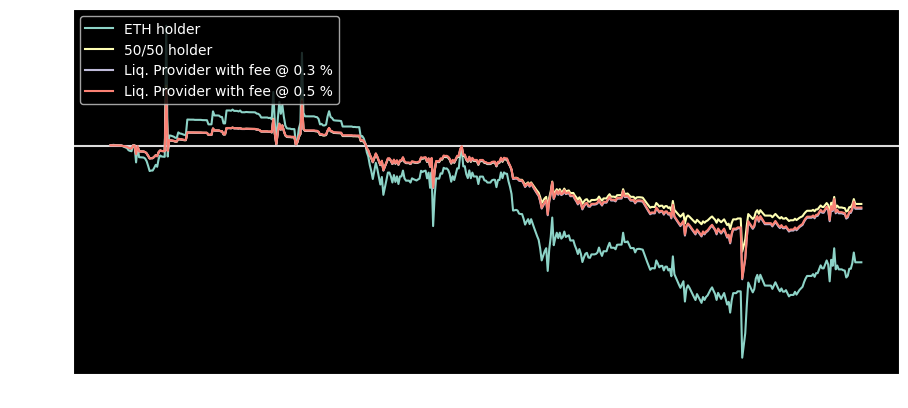

In [5]:
# Agent Type Return Plots
exp_df = add_trading_volume(exp_df)

plot_data = exp_df.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

# create three types of strategies, get their returns
# 50/50: holding half DAI and half ETH
plot_data['50_50_holder_value'] = (0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']).values
plot_data['50_50_holder_return'] = (plot_data['50_50_holder_value']/plot_data['50_50_holder_value'][0] - 1).values

# UNI holder, i.e. liquidity provider
plot_data['UNI_holder_return'] = (plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1).values

# ETH holder
plot_data['ETH_holder_return'] = (plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1).values

plots_df = list()

for i in plot_data['subset'].unique():
    plots_df.append(plot_data[plot_data['subset'] == i].reset_index())

plot_agenttype_return(plots_df, fees)